 #### Coded by: Vikranth

In [1]:
import pandas as pd
from sklearn import ensemble
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib notebook

(179962, 15)
(69818, 3)
(69818, 15)


<IPython.core.display.Javascript object>


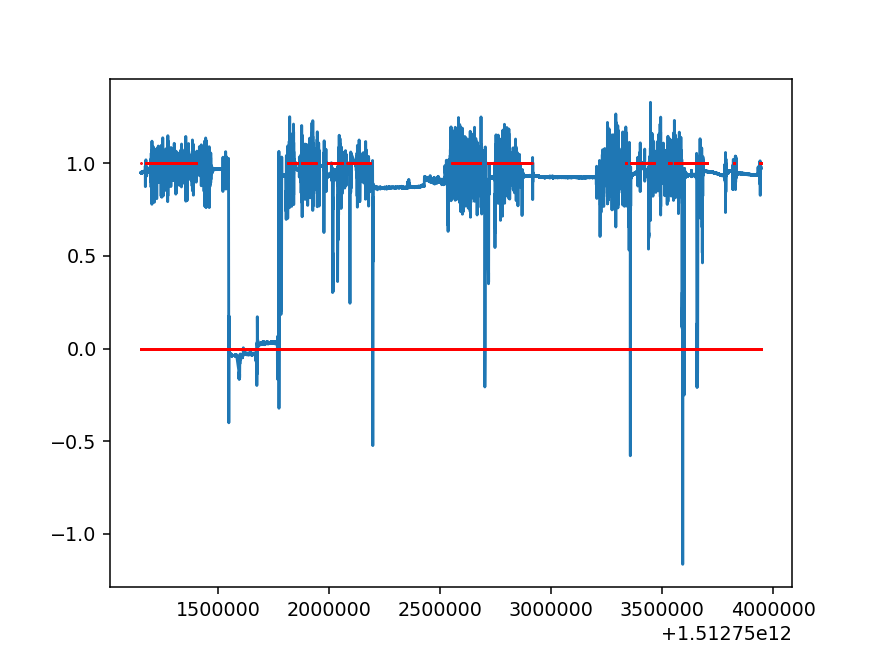

In [2]:
participant_1 = pd.read_pickle('Participant_3.pkl')
#print(participant_1)
labels_1 = np.load('Participant_3_label.npy')
#print(labels_1)

start_time = labels_1[0,0]
end_time = labels_1[-1,0]

dataset = np.copy(participant_1.values)
print(dataset.shape)
print(labels_1.shape)

delta = 40
dataset = dataset[dataset[:,0] >= start_time,:]
dataset = dataset[dataset[:,0] < end_time + delta,:]
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],labels_1[:,2],'r.', ms = 1)
plt.show()

Counter({0.0: 66958, 1.0: 2135, 2.0: 725})
(66958, 1)
(66958, 15)


<IPython.core.display.Javascript object>


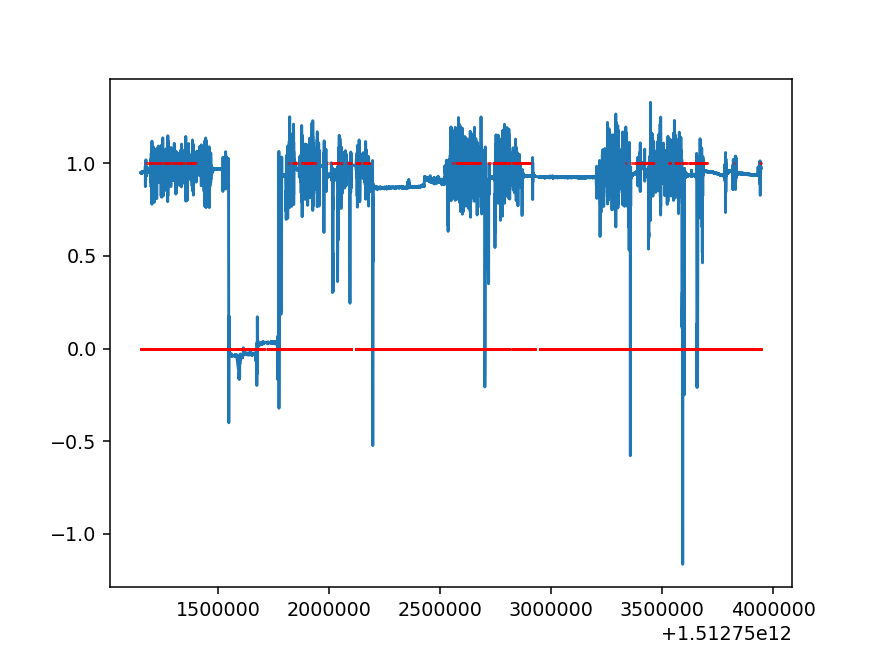

In [3]:
# Remove Missing Data:
missing_1 = dataset[:,13] + dataset[:,14]
print(Counter(missing_1))

dataset = dataset[np.where(missing_1 == 0)]
keypress_labels = labels_1[np.where(missing_1 == 0),2].reshape((-1,1))

print(keypress_labels.shape)
print(dataset.shape)

plt.figure()
plt.plot(dataset[:,0],dataset[:,3])
plt.show()
plt.plot(dataset[:,0],keypress_labels,'r.', ms = 0.1)
plt.show()

In [4]:
dataset_cp = np.copy(dataset[:,1:13])

n_samples, d = dataset_cp.shape
window = 5
stride = 5

data_slide = np.zeros((int((n_samples-window)/stride)+1,window,d))
keypress_labels_cp = np.zeros((int((n_samples-window)/stride)+1,1))
k=0
for i in range(0,n_samples-window,stride): #400ms
    data_slide[k,:,:] = dataset_cp[i:i+window,:]
    keypress_labels_cp[k] = np.amax(keypress_labels[i:i+window])
    k=k+1
    
print (data_slide.shape)
print(keypress_labels_cp.shape)

(13391, 5, 12)
(13391, 1)


In [5]:
Counter(keypress_labels_cp[:,0])

Counter({0.0: 10841, 1.0: 2550})

<IPython.core.display.Javascript object>


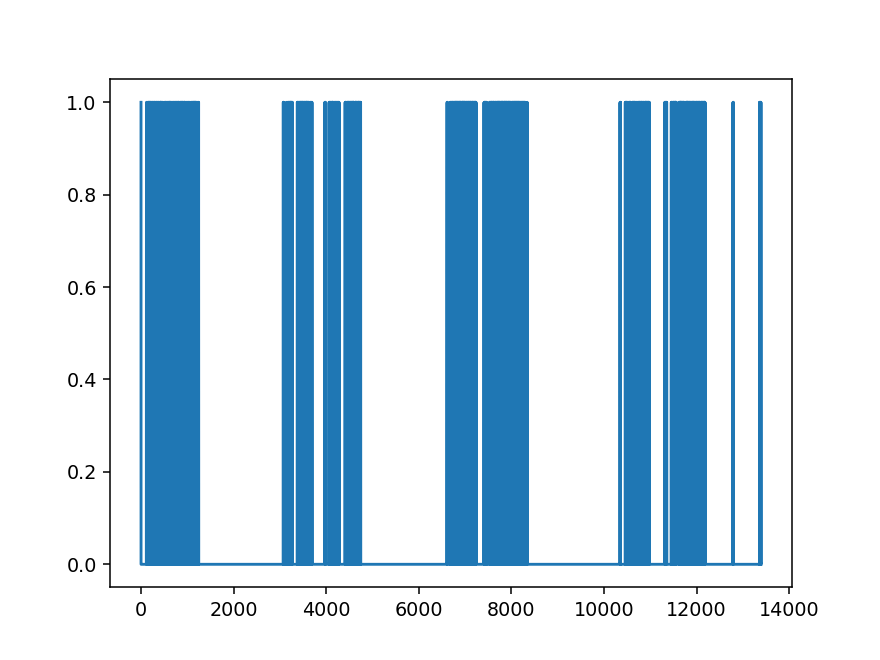

In [6]:
plt.figure()
plt.plot(keypress_labels_cp[:,0])
plt.show()

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Permute, Reshape
from keras import backend as K
from keras.models import load_model

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [8]:
z = 0
X_train0 = data_slide[:z]
Y_train = keypress_labels_cp[0:z].reshape(-1).astype(np.uint8)
X_test0 = data_slide[z:]
Y_test = keypress_labels_cp[z:]
print(np.shape(X_train0))
print(np.shape(Y_train))
print(np.shape(X_test0))
print(np.shape(Y_test))

(0, 5, 12)
(0,)
(13391, 5, 12)
(13391, 1)


In [9]:
num_classes = 2
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

In [10]:
def _data_reshaping(X_train, X_valid, network_type):
    _, win_len, dim = X_train.shape
    #_, dim = X_train.shape
    print(network_type)
    if network_type=='CNN' or network_type=='ConvLSTM':
        
        # make it into (frame_number, dimension, window_size, channel=1) for convNet
        X_train = np.swapaxes(X_train,1,2)
        X_valid = np.swapaxes(X_valid,1,2)

        X_train = np.reshape(X_train, (-1, dim, win_len, 1))
        X_valid = np.reshape(X_valid, (-1, dim, win_len, 1))
    if network_type=='MLP':
        X_train = np.reshape(X_train, (-1, dim*win_len))
        X_valid = np.reshape(X_valid, (-1, dim*win_len))
    
    print (np.shape(X_train))
    print (np.shape(X_train))
    return X_train, X_valid

In [23]:
model = load_model('LSTM_10.h5')

In [24]:
batch_size = 1024
num_feat_map = 16
num_hidden_mlp = 128
num_hidden_lstm = 64

#network_type = 'CNN'
#network_type = 'ConvLSTM'
network_type = 'LSTM'
#network_type = 'MLP'
_, win_len, dim = X_train0.shape
print(win_len)
print(dim)

X_train, X_test = _data_reshaping(X_train0, X_test0, network_type)


5
12
LSTM
(0, 5, 12)
(0, 5, 12)


In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(Y_test, axis=1)
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))


[[8560 2281]
 [1562  988]]
the mean-f1 score: 0.58


<IPython.core.display.Javascript object>


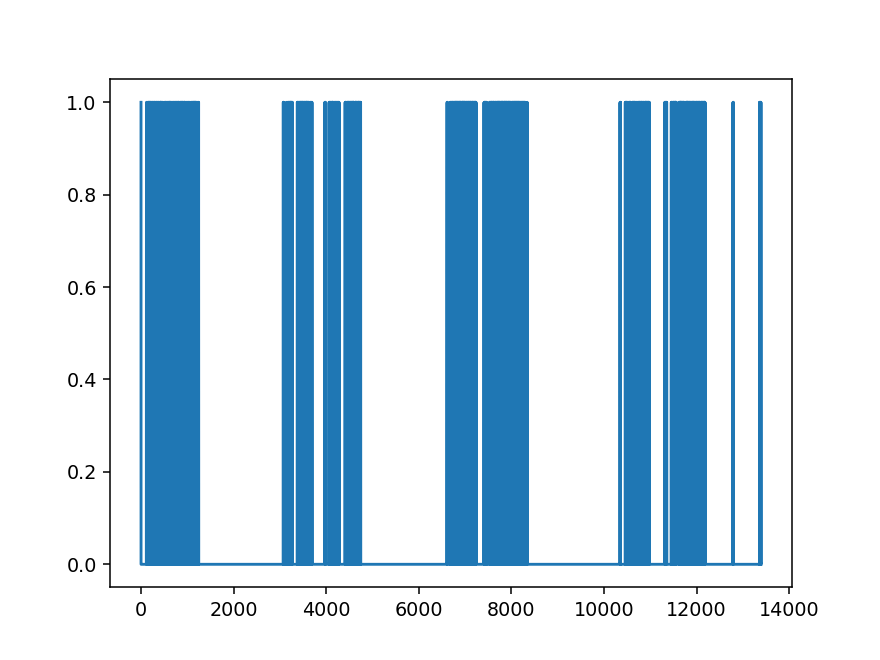

<IPython.core.display.Javascript object>


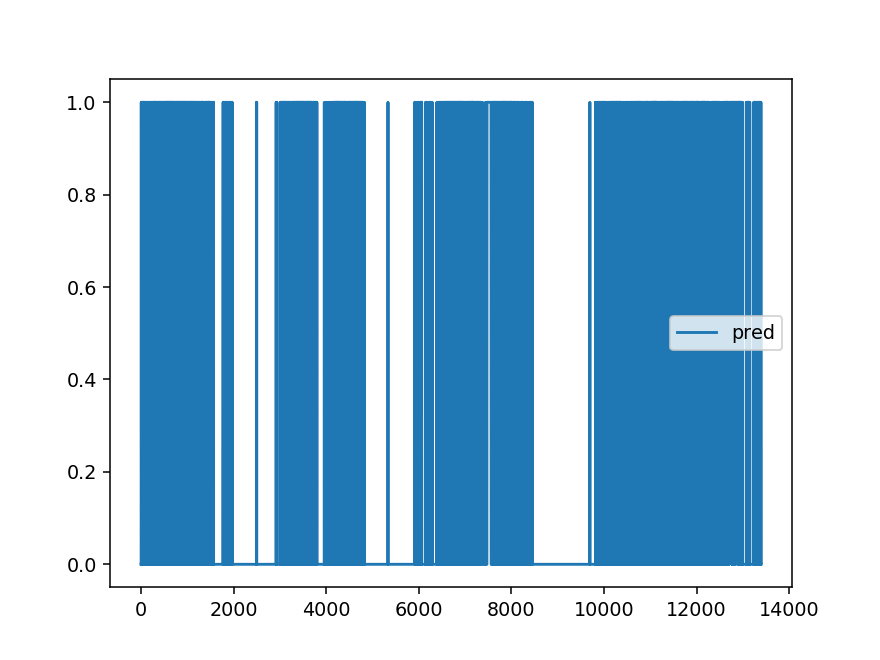

In [26]:
plt.figure()
plt.plot(y_true, label="true")
plt.figure()
plt.plot(y_pred, label="pred")

plt.legend()
plt.show()

In [ ]:
#CNNbn
[[9808 1033]
 [1761  789]]
the mean-f1 score: 0.62

#CNN_LSTM    
[[9604 1237]
 [1675  875]]
the mean-f1 score: 0.62
    
#LSTM
[[7467 3374]
 [1067 1483]]
the mean-f1 score: 0.58
    
